In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import array
import mmap
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import butter, lfilter, freqz
from scipy import signal as ss
from scipy import stats as st
sep = '\\'

In [ ]:
def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups


def load_raw_data(kilosort_folder, recording, num_channels):
    path = os.path.join(kilosort_folder, recording, recording) + '.dat'
    temp_data = np.memmap(path, dtype=np.int16)
    adjusted_len = int(len(temp_data) / num_channels)  # adjust for number of channels

    raw_data = np.memmap(path, dtype=np.int16, shape=(adjusted_len, num_channels))
    return raw_data


def choosing_spike(extracted_spikes, time_chosen):
    Spike_chosen = (extracted_spikes - time_chosen * 30000).abs().argsort()[:1]
    return Spike_chosen


def load_data(recording, kilosort_folder, verbose):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(os.path.join(kilosort_folder, recording))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups


def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values


def band_passfilter(fs, low=None, high=None, order=None):
    low = low / (fs / 2)
    high = high / (fs / 2)
    return ss.butter(N=order, Wn=(low, high), btype='pass')


def apply_filter(array, low, high, fs, order, axis=-1):
    b, a = band_passfilter(fs=fs, low=low, high=high, order=order)
    return ss.filtfilt(b, a, array, axis=axis)


def create_trace_parameters(time_span, extracted_spikes, Spike_chosen):
    num_samples_in_trace = time_span * 30000
    waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))
    start_index = int(extracted_spikes.iloc[Spike_chosen] + waveform_window[0])
    end_index = int((extracted_spikes.iloc[Spike_chosen] + waveform_window[-1]) + 1)
    return start_index, end_index


def extract_highlighted_spikes(time_span, extracted_spikes, Spike_chosen):
    num_samples_in_trace = time_span * 30000
    waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))
    start_index = int(extracted_spikes.iloc[Spike_chosen] + waveform_window[0])
    end_index = int((extracted_spikes.iloc[Spike_chosen] + waveform_window[-1]) + 1)
    highlighted_spike_list = extracted_spikes[(start_index <= extracted_spikes) & (extracted_spikes <= end_index)]
    return highlighted_spike_list


def create_3D_matrix(num_spikes_for_averaging, extracted_spikes, data):
    threeD_matrix = np.zeros((num_spikes_for_averaging, 60, 32))
    waveform_window = np.arange(-30, 30)
    for spike in np.arange(0, num_spikes_for_averaging):
        start_index = int(extracted_spikes.iloc[spike] + waveform_window[0])
        end_index = int((extracted_spikes.iloc[spike] + waveform_window[-1]) + 1)

        waveform = data[start_index:end_index, 0:32]
        threeD_matrix[spike, :, :] = waveform[:, :]
    return threeD_matrix


def extract_trace(Spike_chosen, extracted_spikes, time_span, data, chosen_channel):
    start_index, end_index = create_trace_parameters(time_span, extracted_spikes, Spike_chosen)
    filtered_data = apply_filter(array=data[start_index:end_index, chosen_channel], low=400, high=6000, fs=30000, order=4)
    df_trace = pd.DataFrame({'Value': filtered_data})
    df_trace['time'] = np.arange(start_index / 30000, end_index / 30000, 1 / 30000)
    return df_trace


def choose_channel(Spike_chosen, extracted_spikes, time_span, data, broken_chans, num_spikes_for_averaging):
    start_index, end_index = create_trace_parameters(time_span, extracted_spikes, Spike_chosen)
    temporary_df = pd.DataFrame(data[start_index:end_index])
    if broken_chans:
        for chan in broken_chans:
            temporary_df.drop((chan), inplace=True, axis=1)

    threeD_matrix = create_3D_matrix(num_spikes_for_averaging, extracted_spikes, data)

    mean_waveform = np.mean(threeD_matrix, axis=0)
    waveform_per_channel_df = pd.DataFrame(mean_waveform)
    maxes = waveform_per_channel_df.apply(np.min, axis=0)
    chosen_channel = maxes.idxmin()
    return chosen_channel


def spike_highlight(spike, extracted_spikes, data, chosen_channel):
    window_for_highlight = np.arange(-30, 30)
    start_highlight = int(spike + window_for_highlight[0])
    end_highlight = int((spike + window_for_highlight[-1]) + 1)
    filtered_highlight_data = apply_filter(array=data[start_highlight:end_highlight, chosen_channel], low=400, high=6000, fs=30000, order=4)
    df_highlight = pd.DataFrame({'Value': filtered_highlight_data})
    df_highlight['time'] = np.arange(start_highlight, end_highlight, 1)
    df_highlight_final = pd.DataFrame({'time': df_highlight['time'] / 30000, 'Value': df_highlight['Value']})
    return df_highlight_final


def plot_final_data(kilosort_folder, recording, chosen_channel, chosen_cluster, highlighted_spike_list, time_chosen):
    fig_folder =  os.path.join(kilosort_folder, recording, 'figures', 'Cluster no.' + str(chosen_cluster))
    plt.ylim(-2000, 2000)
    plt.tick_params(axis='both', which='major', labelsize=20)
    #plt.xlabel('time (s)', fontsize=28)
    #plt.ylabel('amplitude', fontsize=28)
    #plt.title('Recording: {0} \n Channel: {1} \n Cluster: {2}' .format(recording, chosen_channel, chosen_cluster), fontsize=28)
    #plt.annotate('no. of spikes: {}'.format(len(highlighted_spike_list)), xy=(time_chosen, 1500), xytext=(time_chosen, 1500), size=30)
    mkdirs_(fig_folder)
    plt.tight_layout()
    if time_chosen >= 60*60: 
        figpath = os.path.join(kilosort_folder, recording, 'figures', 'Cluster no.' + str(chosen_cluster), recording + ' Cluster no.' + str(chosen_cluster) + ' After.png')
    else:
        figpath = os.path.join(kilosort_folder, recording, 'figures', 'Cluster no.' + str(chosen_cluster), recording + ' Cluster no.' + str(chosen_cluster) + ' Before.png')
    plt.savefig(figpath)


def choose_cluster_to_plot(cluster_groups, spike_clusters, spike_times, chosen_cluster):
    good_cluster_numbers = get_good_cluster_numbers(cluster_groups)
    df = pd.DataFrame({'cluster': spike_clusters.flatten(), 'spike_times': spike_times.flatten()})
    df = df.loc[df['cluster'].isin(good_cluster_numbers)]
    cluster_to_plot = good_cluster_numbers[good_cluster_numbers == chosen_cluster][0]
    return df, cluster_to_plot

def mkdirs_(path):
    if not os.path.exists(path):
        os.mkdir(path)


In [ ]:
kilosort_folder = r'F:\CIT_WAY'
recording = '2018-05-01_01'
num_channels = 32
chosen_cluster = 0
time_chosen = 3000
time_span = 1
broken_chans = [22]
num_spikes_for_averaging = 3000
color = 'b'
verbose = True 

In [ ]:
df

In [ ]:
data = load_raw_data(kilosort_folder=kilosort_folder,
                         recording=recording,
                         num_channels=num_channels)
spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                            kilosort_folder=kilosort_folder,
                                                            verbose=verbose)
df, cluster_to_plot = choose_cluster_to_plot(cluster_groups=cluster_groups,
                                                 spike_clusters=spike_clusters,
                                                 spike_times=spike_times,
                                                 chosen_cluster=chosen_cluster)

#extracted_spikes = df[df['cluster'] == cluster_to_plot]['spike_times']
Spike_chosen = choosing_spike(extracted_spikes=df['spike_times'],
                                  time_chosen=time_chosen)

start_index, end_index = create_trace_parameters(time_span=time_span, extracted_spikes=df['spike_times'], Spike_chosen=Spike_chosen)

f, a = plt.subplots(32-len(broken_chans), 1, sharey=True, figsize=(35, 160))

colorlist = []
for name, hex in matplotlib.colors.cnames.items():
    colorlist.append(name)


for channel in np.arange(0, 32 - len(broken_chans)):
    
    df_trace = extract_trace(Spike_chosen=Spike_chosen, extracted_spikes=df['spike_times'], time_span=time_span, data=data, chosen_channel=channel)

    a[channel].plot(df_trace['time'], df_trace['Value'], color='gray')


    good_cluster_numbers = get_good_cluster_numbers(cluster_groups)

    num_samples_in_trace = time_span * 30000
    waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))    
    start_index = int(df['spike_times'].iloc[Spike_chosen] + waveform_window[0])
    end_index = int((df['spike_times'].iloc[Spike_chosen] + waveform_window[-1]) + 1)


    for ind, cluster in enumerate(good_cluster_numbers):
        new_extracted_spikes = df[df['cluster'] == cluster]['spike_times']
        highlighted_spike_list = new_extracted_spikes[(start_index <= new_extracted_spikes) & (new_extracted_spikes <= end_index)]
        if len(highlighted_spike_list)==0:
            pass
        else:
            for spike in highlighted_spike_list:  # loop over each spike in original trace. Plot in color
                df_highlight = spike_highlight(spike=spike,
                                                   extracted_spikes=new_extracted_spikes,
                                                   data=data,
                                                   chosen_channel=channel)
                a[channel].plot(df_highlight['time'], df_highlight['Value'], color=colorlist[ind])

plot_final_data(kilosort_folder=kilosort_folder, recording=recording, chosen_channel=channel, chosen_cluster=chosen_cluster, highlighted_spike_list = highlighted_spike_list, time_chosen=time_chosen)


# Individual waveform extraction


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [27]:
font = {'fontname':'Calibri'}

def load_kilosort_arrays(kilosort_folder, recording, verbose):
    if verbose:
        print('Loading Kilosort arrays: {}\n\n'.format(recording))
    path = os.path.join(kilosort_folder, recording)
    spike_clusters = np.load(os.path.join(path, 'spike_clusters.npy'))
    spike_times = np.load(os.path.join(path, 'spike_times.npy'))
    cluster_groups = pd.read_csv(os.path.join(path, 'cluster_groups.csv'), sep='\t')

    return spike_clusters, spike_times, cluster_groups


def load_raw_data(kilosort_folder, recording, num_channels):
    path = os.path.join(kilosort_folder, recording, recording) + '.dat'
    temp_data = np.memmap(path, dtype=np.int16)
    adjusted_len = int(len(temp_data) / num_channels)  # adjust for number of channels

    raw_data = np.memmap(path, dtype=np.int16, shape=(adjusted_len, num_channels))
    return raw_data


def get_good_cluster_numbers(cluster_groups):
    good_clusters = cluster_groups[cluster_groups['group'] == 'good']
    return good_clusters['cluster_id'].values


def gen_good_spikes_df(spike_times, spike_clusters, good_cluster_numbers):
    all_spikes_df = pd.DataFrame({'spike_time': spike_times.flatten(),
                                  'spike_cluster': spike_clusters.flatten()})
    good_spikes_df = all_spikes_df[all_spikes_df['spike_cluster'].isin(good_cluster_numbers)]
    return good_spikes_df


def gen_spiketimes_series(good_spikes_df, cluster, num_spikes, last_spikes):
    if len(good_spikes_df) < num_spikes:
        num_spikes = len(good_spikes_df)
    if last_spikes:
        spike_times = good_spikes_df[good_spikes_df['spike_cluster'] == cluster].iloc[-num_spikes:]
    else:
        spike_times = good_spikes_df[good_spikes_df['spike_cluster'] == cluster].iloc[num_spikes:]
    spike_times.index = range(len(spike_times))
    return spike_times


def extract_waveforms(num_spikes, num_samples, num_channels,
                      spike_times, raw_data):
    waveform_window = np.arange(-num_samples / 2, num_samples / 2)
    cols = [''.join(['Chan_', str(num)]) for num in range(0, num_channels)]

    if num_spikes >= len(spike_times['spike_time']):
        num_spikes = len(spike_times['spike_time']) - 20

    empty_template = np.zeros((num_spikes, num_samples, num_channels))
    for spike in range(num_spikes):
        start_index = int(spike_times['spike_time'].iloc[spike] + waveform_window[0])
        end_index = int((spike_times['spike_time'].iloc[spike] + waveform_window[-1]) + 1)
        waveform = raw_data[start_index:end_index, :]
        empty_template[spike, :, :] = waveform[:, :]

    waveform_per_chan = np.mean(empty_template, axis=0)
    waveform_per_chan = pd.DataFrame(waveform_per_chan, columns=cols)
    return waveform_per_chan


def choose_channel(df, method, broken_chans):
    '''
    Choose either channel with max or minumum values
    method == 'max' or 'min'
    '''
    if broken_chans:
        for chan in broken_chans:
            df.drop('Chan_{}'.format(str(chan)), inplace=True, axis=1)
    if method.lower() == 'max':
        chan = df.apply(np.max, axis=0)
        selected_chan = df.loc[:, chan.idxmax()]
        chan = chan.idxmax()
    elif method.lower() == 'min':
        chan = df.apply(np.min, axis=0)
        selected_chan = df.loc[:, chan.idxmin()]
        chan = chan.idxmin()
    else:
        raise ValueError('Unable to parse channel selection method.\nEnter \'min\' or\'max\'')

    return selected_chan, chan


def gen_peak_finding_df(chan_df):
    df = pd.DataFrame({'y_values': chan_df})
    df['y_values'] = df['y_values'].rolling(5).mean()
    df['diff'] = df.diff(periods=1)
    df['change'] = (df['diff'] >= 0).map({True: 'increase', False: 'decrease'})
    return df


def calculate_spikewidth(spike_type, fs, cluster, recording, **kwargs):
    divisor = int(round(fs / 1000))
    SWs = {'spike_type': spike_type, 'cluster': cluster, 'recording': recording}
    if spike_type == 'up_down_up':
        try:
            SWs['SW_peak'] = np.absolute(kwargs['peak_sample'] - kwargs['baseline_sample']) / divisor
            SWs['SW_troff'] = np.absolute(kwargs['min_sample'] - kwargs['baseline_sample']) / divisor
            SWs['SW_return'] = np.absolute(kwargs['return_sample'] - kwargs['baseline_sample']) / divisor
            SWs['min_max_amp'] = kwargs['peak_amp'] + np.absolute(kwargs['min_amp'])
            SWs['base_min_amp'] = kwargs['baseline_amp'] + np.absolute(kwargs['min_amp'])
        except:
            SWs['SW_peak'] = np.nan
            SWs['SW_troff'] = np.nan
            SWs['SW_return'] = np.nan
            SWs['min_max_amp'] = np.nan
            SWs['base_min_amp'] = np.nan
    elif spike_type == 'down_up':
        try:
            SWs['SW_peak'] = np.nan
            SWs['SW_troff'] = np.absolute(kwargs['min_sample'] - kwargs['baseline_sample']) / divisor
            SWs['SW_return'] = np.absolute(kwargs['return_sample'] - kwargs['baseline_sample']) / divisor
            SWs['base_min_amp'] = kwargs['baseline_amp'] + np.absolute(kwargs['min_amp'])
        except:
            SWs['SW_peak'] = np.nan
            SWs['SW_troff'] = np.nan
            SWs['SW_return'] = np.nan
            SWs['min_max_amp'] = np.nan
            SWs['base_min_amp'] = np.nan
    return SWs


def find_baseline_return(df, baseline_amp, min_sample):
    try:
        increasing = df.loc[(df['y_values'] < baseline_amp) & (df['change'] == 'increase') & (df.index > min_sample)]

        if (increasing.reset_index().set_index('index', drop=False)['index'].diff() > 1).any():
            last_name = increasing[increasing.reset_index().set_index('index', drop=False)['index'].diff() > 1].iloc[0].name
            increasing = increasing.iloc[:increasing.index.get_loc(last_name)]
        return increasing.iloc[-1].name, increasing.iloc[-1]['y_values']
    except:
        return np.nan


def find_baseline_up_down_up(df, num_samples, thresh):
    '''
    Function to find baseline for up-down-up
    '''
    from_start_to_max = np.arange(2, df['y_values'].iloc[:int(num_samples / 2)].idxmax() + 1, 1)
    for time_point in from_start_to_max:
        if np.absolute(df.loc[time_point][0] - df.loc[time_point - 2][0]) > thresh and df.loc[time_point]['change'] == 'increase':
            return time_point


def up_down_up(df, fig_folder, cluster, recording, num_samples, thresh=10, fs=30000):

    half_samples = int(num_samples / 2)
    peak_amp = df['y_values'].iloc[:half_samples].max()
    peak_sample = df['y_values'].iloc[:half_samples].idxmax()

    min_amp = df['y_values'].min()
    min_sample = df['y_values'].idxmin()

    baseline_amp = peak_amp * 0.05
    baseline_sample = find_baseline_up_down_up(df=df,
                                               num_samples=num_samples,
                                               thresh=thresh)
    return_sample, return_amp = find_baseline_return(df, baseline_amp, min_sample)

    SWs = calculate_spikewidth(spike_type='up_down_up',
                               fs=fs,
                               recording=recording,
                               cluster=cluster,
                               peak_sample=peak_sample,
                               baseline_sample=baseline_sample,
                               baseline_amp=baseline_amp,
                               min_sample=min_sample,
                               peak_amp=peak_amp,
                               return_sample=return_sample,
                               min_amp=min_amp)
    if baseline_sample:
        plot_points(baseline_sample, min_sample, return_sample, df=df, cluster=cluster, fig_folder=fig_folder)
    return pd.DataFrame(SWs, index=[0])


def find_baseline_down_up(df, thresh):
    '''
    Same as standard baseline except the value is the first point where there's a significant y-value DECREASE
    '''

    from_start_to_min = np.arange(2, df['y_values'].idxmin(), 1)
    if len(from_start_to_min) > 1:
        for time_point_for_down_up in from_start_to_min:
            if (np.absolute(df.loc[time_point_for_down_up][0] - df.loc[time_point_for_down_up - 2][0]) > thresh) and (df.loc[time_point_for_down_up]['change'] == 'decrease'):
                return time_point_for_down_up - 4
    else:
        return np.nan


def down_up(df, fig_folder, num_samples, recording, cluster, thresh, chan, fs=30000):
    min_amp = df['y_values'].min()
    min_sample = df['y_values'].idxmin()

    baseline_amp = np.mean(df['y_values'].iloc[:int(num_samples / 2)])
    baseline_sample = find_baseline_down_up(df, thresh)
    try:
        return_sample, return_amp = find_baseline_return(df, baseline_amp, min_sample)
    except:
        return_sample = np.nan
        return_amp = np.nan

    SWs = calculate_spikewidth(spike_type='down_up',
                               fs=fs,
                               recording=recording,
                               cluster=cluster,
                               baseline_sample=baseline_sample,
                               min_sample=min_sample,
                               return_sample=return_sample,
                               baseline_amp=baseline_amp,
                               min_amp=min_amp)
    try:
        plot_points(baseline_sample, min_sample, return_sample, df=df, cluster=cluster, fig_folder=fig_folder)
    finally:
        return pd.DataFrame(SWs, index=[0])


def plot_points(*args, df, cluster, fig_folder):
    f, a = plt.subplots(figsize=(8, 8))
    df['y_values'].plot(ax=a)
    for arg in args:
        x_values = np.ones(2) * arg
        y_values = np.linspace(np.min(df['y_values']), np.max(df['y_values']), 2)
        a.plot(x_values, y_values)
        a.set_title('cluster:\t {}'.format(str(cluster)))
    if not os.path.exists(os.path.join(fig_folder, 'spike_widths')):
        os.mkdir(os.path.join(fig_folder, 'spike_widths'))
    plt.savefig(os.path.join(fig_folder, 'spike_widths', str(cluster)) + '.png')
    plt.close()


def merge_dfs(df_list, broadcast, **kwargs):
    df = pd.concat(df_list)
    df.index = range(len(df))
    if broadcast:
        df['recording'] = kwargs['recording']
    return df


def plot_waveform(all_chans_df, recording, one_chan_df, method, chan, cluster, fig_folder):
    f, a = plt.subplots(figsize=(20, 8), ncols=3)

    all_chans_df.iloc[:, :15].plot(ax=a[0], title='All channels: Shank 1')
    all_chans_df.iloc[:, 15:].plot(ax=a[1], title='All channels: Shank 2')
    one_chan_df.plot(ax=a[2], title='Cluster number {clus}:\t{chan}'.format(clus=str(cluster), chan=chan))
    plt.show()


In [48]:
recording='2018-05-01_01'
kilosort_folder=r'F:\CIT_WAY'
num_spikes=1100
num_channels=32
num_samples=240
last_spikes=False
spike_selection_method='min'
borken_channels=[22]
cluster_list = [20]
color_list = ['#E1E100']
verbose=True

In [49]:
spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(recording=recording,
                                                                           kilosort_folder=kilosort_folder, verbose=verbose)
raw_data = load_raw_data(recording=recording,
                                 kilosort_folder=kilosort_folder,
                                 num_channels=num_channels)
good_cluster_numbers = get_good_cluster_numbers(cluster_groups)
good_spikes_df = gen_good_spikes_df(spike_times=spike_times,
                                            spike_clusters=spike_clusters,
                                            good_cluster_numbers=good_cluster_numbers)

Loading Kilosort arrays: 2018-05-01_01




In [50]:
np.linspace(0, one_channel.shape[0], 6)/3000

array([0.   , 0.016, 0.032, 0.048, 0.064, 0.08 ])

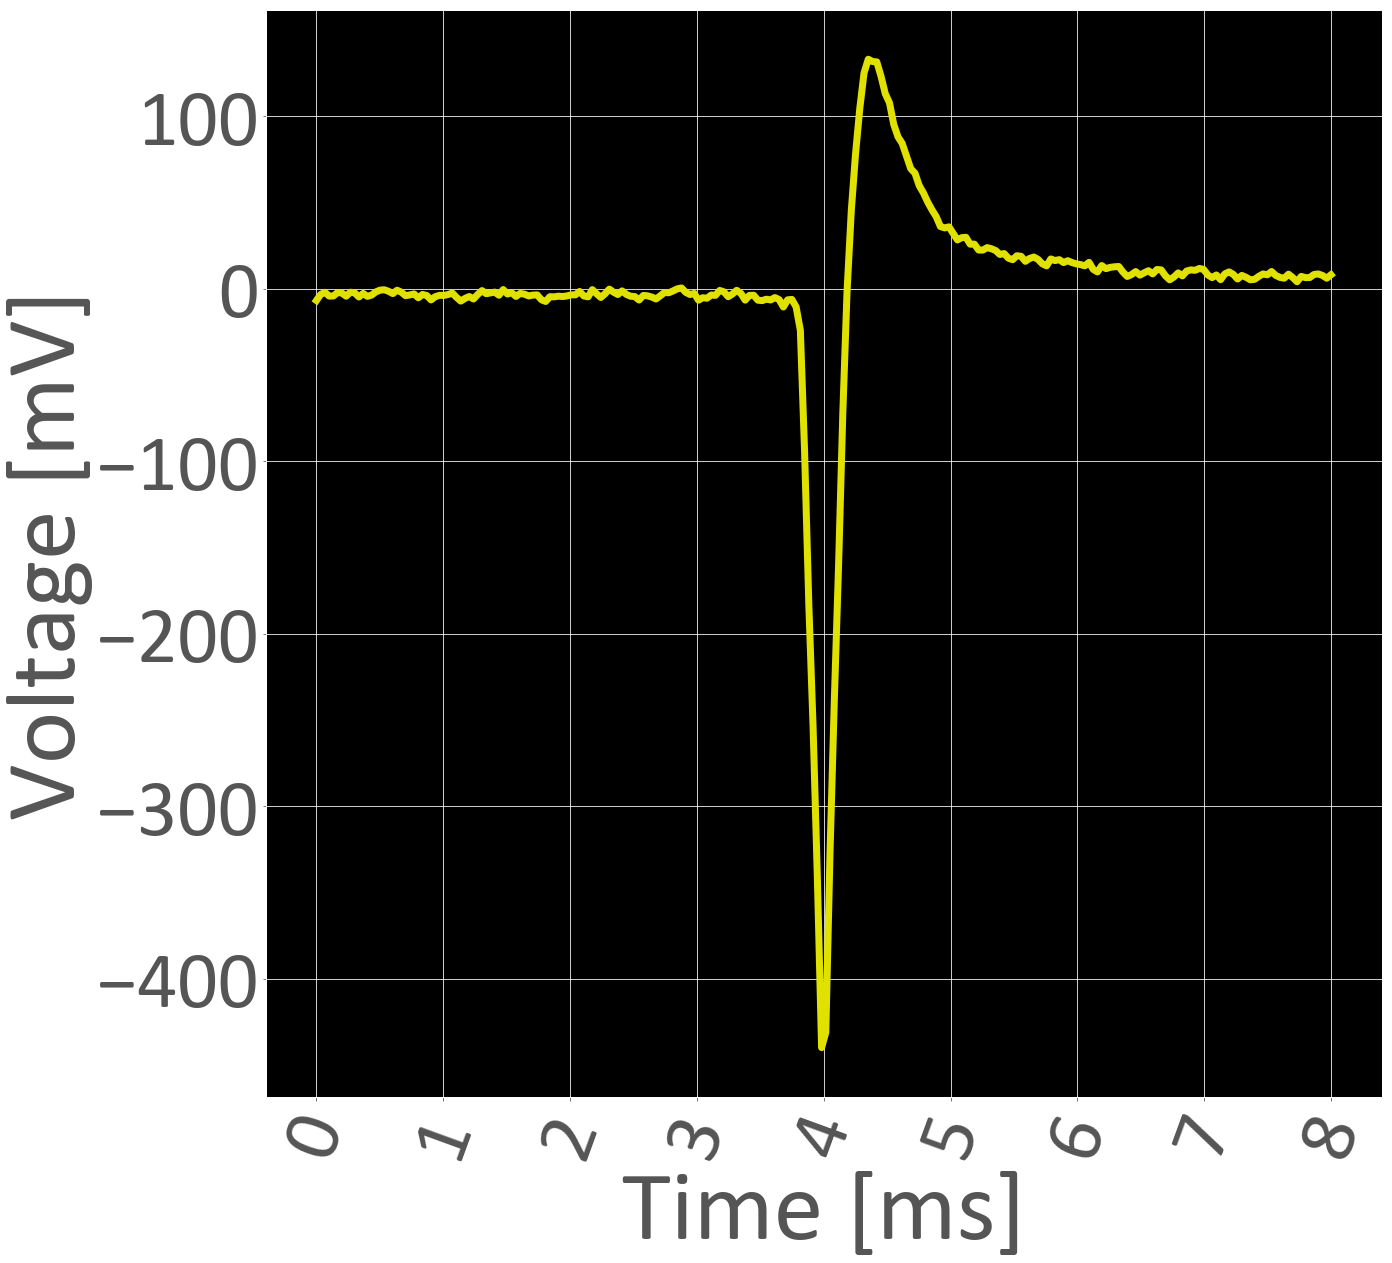

In [51]:

plt.figure(figsize = (20,20))
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='k'
plt.rcParams['lines.linewidth']=2
for ind, cluster in enumerate(cluster_list):
    spiketimes_series = gen_spiketimes_series(good_spikes_df=good_spikes_df,
                                                          cluster=cluster,
                                                          num_spikes=num_spikes,
                                                          last_spikes=last_spikes)
    waveform_per_chan = extract_waveforms(num_spikes=num_spikes,
                                                      num_samples=num_samples,
                                                      num_channels=num_channels,
                                                      spike_times=spiketimes_series,
                                                      raw_data=raw_data)
    one_channel, chan = choose_channel(df=waveform_per_chan,
                                                   method=spike_selection_method,
                                                   broken_chans=borken_channels)
    plt.plot(np.linspace(0, one_channel.shape[0], one_channel.shape[0])/30,one_channel, color=color_list[ind], linewidth=7)
    #one_channel.plot(title='Cluster number {clus}:\t{chan}'.format(clus=str(cluster), chan=chan), color=color_list[ind])
    plt.xlabel('Time [ms]', **font, fontsize=100)
    plt.ylabel('Voltage [mV]', **font, fontsize=100)
    plt.yticks(**font, fontsize=80)
    plt.xticks(**font, fontsize=80, rotation=70)
    plt.savefig(r'C:\Users\ASUS\Desktop\Images\waveform pics\Gold Neuron.png', dpi=600)